In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
import osmnx as ox
import numpy as np
import networkx as nx
import pyrosm
import contextily as cx 

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
ox.__version__

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


'1.1.2'

In [2]:
filename = "lejeboliger_2019_t_april23.csv"

In [3]:
df = pd.read_csv(filename, sep= ";", decimal = ".", dtype={'antal værelser': object, 'lon': float, 'lat': float})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540 entries, 0 to 2539
Data columns (total 96 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   leje                                        2540 non-null   int64  
 1   forudbetalt_leje                            2360 non-null   float64
 2   tilgængelig_fra                             2540 non-null   object 
 3   tilgængelig_til                             5 non-null      object 
 4   max_lejeperiode_måned                       36 non-null     float64
 5   Sagsnr                                      2540 non-null   object 
 6   udbetaling                                  2540 non-null   int64  
 7   realtor_name                                2540 non-null   object 
 8   realtor_zip_code                            2540 non-null   int64  
 9   realtor_road                                2540 non-null   object 
 10  realtor_hous

In [4]:
# Hver leje har et unikt sagsnummer 
duplicates = df['Sagsnr'].duplicated()
duplicates_df = df[duplicates]
duplicates_df

,leje,forudbetalt_leje,tilgængelig_fra,tilgængelig_til,max_lejeperiode_måned,Sagsnr,udbetaling,realtor_name,realtor_zip_code,realtor_road,...,highlighted_until,cadastral_district_id,land_parcel_id,distinction,weighted_area,realtor_deleted,per_area_price,secondary_address_type,custom_areas,utilities_connection_fee_included_in_price


In [5]:
# columns from boligzonen: ["rooms", "area", "rent", "street", "zip_code", "latitude", "longitude"]
columns = ["Sagsnr", "tilgængelig_fra", "antal værelser", "boligareal", "leje", "road_name", "zip_code", "lat", "lon"]
df = df[columns]
df2 = df.rename(columns={"tilgængelig_fra": "available_from", "antal værelser": "rooms", "boligareal": "area", "leje": "rent", "road_name": "street", "lon": "longitude", "lat" : "latitude"})

In [6]:
gdf = gpd.GeoDataFrame(
    df2, geometry=gpd.points_from_xy(df.lon, df.lat))

In [7]:
gdf[:10]

,Sagsnr,available_from,rooms,area,rent,street,zip_code,latitude,longitude,geometry
0,1770011017177hom,2023-01-25,4,128.0,21500,Teglholmens Østkaj,2450,55.649226,12.553821,POINT (12.55382 55.64923)
1,1770011439177hom,2023-03-29,2,81.0,16700,Islands Brygge,2300,55.658052,12.567339,POINT (12.56734 55.65805)
2,1770010150177009,2022-10-28,1,29.0,7500,Poul Bundgaards Vej,2500,55.659268,12.510115,POINT (12.51012 55.65927)
3,11803546,2023-02-01,5,140.0,18600,A.C. Meyers Vænge 46,2450,55.651663,12.542862,POINT (12.54286 55.65166)
4,199500004911995004,2022-09-14,3,93.0,15000,C.F. Møllers Allé,2300,55.634762,12.577208,POINT (12.57721 55.63476)
5,1770008128177009,2022-05-30,1,33.0,9050,Dybbølsbro,1577,55.663636,12.560093,POINT (12.56009 55.66364)
6,1770011493177hom,2023-03-24,1,31.0,7400,Gl. Køge Landevej,2500,55.655716,12.511556,POINT (12.51156 55.65572)
7,10-X00021283426001,2023-01-05,3,99.0,14050,Ørestads Boulevard,2300,55.636141,12.582915,POINT (12.58292 55.63614)
8,1770011448177hom,2023-03-13,2,29.0,10900,Finsensvej,2000,55.680762,12.518316,POINT (12.51832 55.68076)
9,1770011266177hom,2023-03-17,4,103.0,15400,Emma Gads Vej,2300,55.637016,12.580259,POINT (12.58026 55.63702)


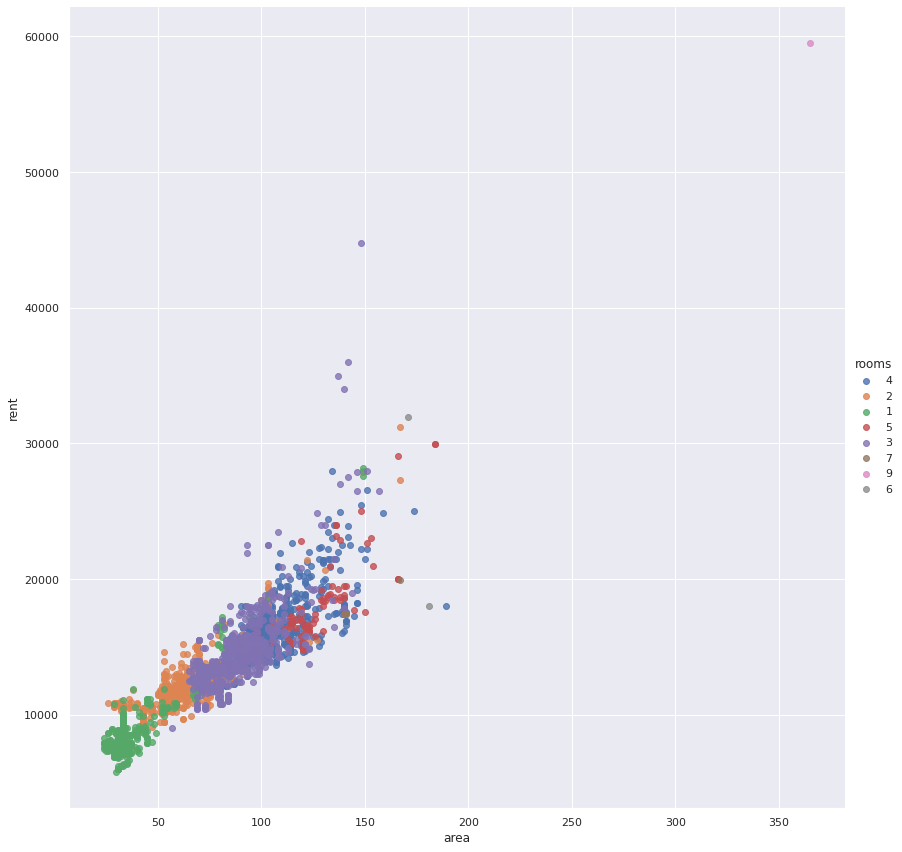

In [8]:
# Plotting 

import seaborn as sns

sns.set(rc={'figure.figsize':(26,12)})
sns.lmplot('area', 'rent', data=df2, hue='rooms', fit_reg=False, height=12, aspect=1)

plt.show()

In [9]:
#geometry = gdp.points_from_xy(df2.longitude, df2.latitude, crs="EPSG:4326")
gdf = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2.longitude,df2.latitude, crs="EPSG:4326"))

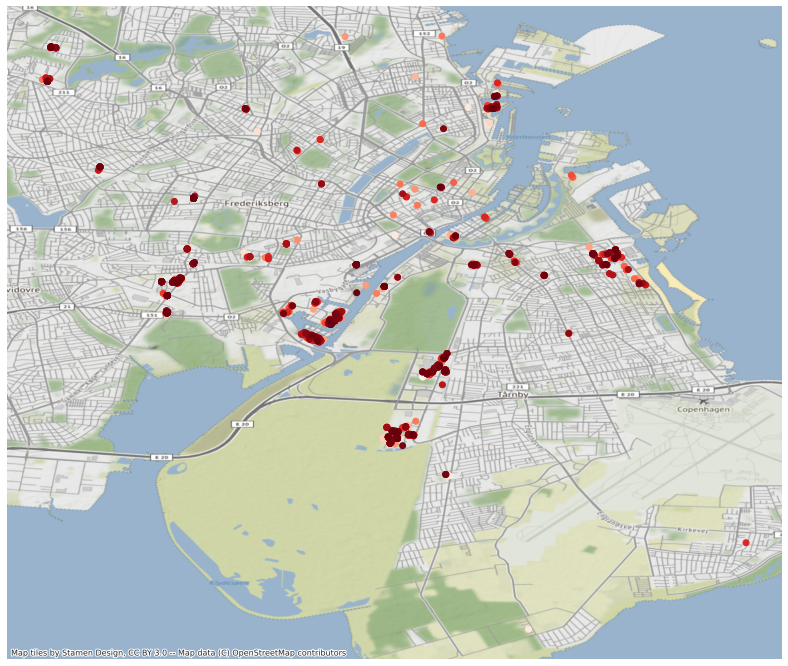

In [10]:
ax = gdf.plot(c=gdf["rent"], cmap='Reds', legend=True) #color="black")
ax.set_axis_off()
cx.add_basemap(ax, crs=gdf.crs)

cmap = plt.cm.get_cmap('cool')
cmap.set_under('red')